<h1>Feed-Forward Neural Network</h1> 


<h3 style="color: yellow;">This tutorial covers the implementation of a feedforward neural network for digit classification using the MNIST dataset.</h3>

<h3 style="color: yellow;">This tutorial builds upon the previous tutorials where we utilized:</h3>


<ul>
  <li><span style="color:yellow; font-size: 110%;">DataLoader for loading the MNIST dataset.</span></li>
  <li><span style="color:yellow; font-size: 110%;">Transform for MNIST dataset transformation.</span></li>
  <li><span style="color:yellow; font-size: 110%;">nn.Module to construct our model with an input layer, a hidden layer, and an output layer.</span></li>
  <li><span style="color:yellow; font-size: 110%;">Activation functions ReLU and Softmax (Softmax embedded within the loss).</span></li>
  <li><span style="color:yellow; font-size: 110%;">Loss and optimization.</span></li>
  <li><span style="color:yellow; font-size: 110%;">Batch training loop.</span></li>
  <li><span style="color:yellow; font-size: 110%;">Model evaluation.</span></li>
  <li><span style="color:yellow; font-size: 110%;">GPU support.</span></li>
</ul>




<div style="display: flex; justify-content: center;">
    <img src='bio_activation.png' width=500>
</div>


In [29]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [30]:
# Device config
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')


In [31]:
# Hyper-parameters definition
INPUT_SIZE=784 # 28*28 image size
HIDDEN_SIZE=200
OUTPUT_SIZE=10
EPOCHS=10
BATCH_SIZE=64
LR=0.001

In [32]:
# MNIST dataset
train_dataset=torchvision.datasets.MNIST(root='./data',
                                         train=True,
                                         transform=transforms.ToTensor(),download=True)

test_dataset=torchvision.datasets.MNIST(root='./data',train=False,
                                        transform=transforms.ToTensor())

In [33]:
# DataLoader
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=True)

# Print the first batch by converting the train_loader into an iterator object.
batch_iter=iter(train_loader)
samples, labels=next(batch_iter)
print(f'The shape of the first batch: {samples.shape} || The shape of the first batch of labels {labels.shape}')
# [64,1,28,28]---> [batch,channel,nrows,ncolumns]


The shape of the first batch: torch.Size([64, 1, 28, 28]) || The shape of the first batch of labels torch.Size([64])


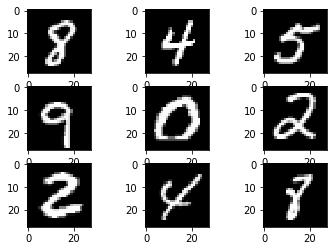

In [34]:
# Plot a sample of  images
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(samples[i][0],cmap='gray') # We use samples[i][0] with [0] since we intend to access the first channel.
plt.show()
    

In [35]:
# Model 
class NNET(nn.Module):
    def __init__(self, INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE, *args, **kwargs):
        super(NNET,self).__init__(*args, **kwargs)
        self.l1=nn.Linear(INPUT_SIZE,HIDDEN_SIZE)
        self.relu=nn.ReLU(self.l1)
        self.l2=nn.Linear(HIDDEN_SIZE,OUTPUT_SIZE) # OUTPUT_SIZE == Numof example
    
    def forward(self,x):
        out=self.relu(self.l1(x))
        out=self.l2(out) 
        #Note: In this context, we refrain from using an activation function due to our intention to apply the binary cross-entropy loss, which inherently incorporates the activation function
        return out    


In [36]:
# model, loss, and optimization
model=NNET(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE).to(device)
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [37]:
# Training loop
N_TOTAL_STEPS=len(train_loader)
for epoch in range(EPOCHS):
    for i, (samples,labels) in enumerate(train_loader):
        # data shape= [100,1,28,28] we have to reahpe the data to be in  shape of 100 x 784
        samples=samples.reshape(-1,28*28).to(device)
        labels=labels.to(device)
        
        # forward pass
        outputs=model(samples)
        loss_=loss(outputs,labels)
        
        # backward pass
        optimizer.zero_grad() 
        loss_.backward()
        optimizer.step() # update the parameters 
        
        if (i+1) % 50   ==0:
            print(f'epoch {epoch+1}/ {EPOCHS}, step {i+1}/{N_TOTAL_STEPS}, loss ={loss_.item():.3f}')


epoch 1/ 10, step 50/938, loss =0.648


epoch 1/ 10, step 100/938, loss =0.489
epoch 1/ 10, step 150/938, loss =0.366
epoch 1/ 10, step 200/938, loss =0.213
epoch 1/ 10, step 250/938, loss =0.225
epoch 1/ 10, step 300/938, loss =0.154
epoch 1/ 10, step 350/938, loss =0.170
epoch 1/ 10, step 400/938, loss =0.364
epoch 1/ 10, step 450/938, loss =0.183
epoch 1/ 10, step 500/938, loss =0.356
epoch 1/ 10, step 550/938, loss =0.152
epoch 1/ 10, step 600/938, loss =0.210
epoch 1/ 10, step 650/938, loss =0.346
epoch 1/ 10, step 700/938, loss =0.228
epoch 1/ 10, step 750/938, loss =0.334
epoch 1/ 10, step 800/938, loss =0.329
epoch 1/ 10, step 850/938, loss =0.139
epoch 1/ 10, step 900/938, loss =0.129
epoch 2/ 10, step 50/938, loss =0.118
epoch 2/ 10, step 100/938, loss =0.054
epoch 2/ 10, step 150/938, loss =0.172
epoch 2/ 10, step 200/938, loss =0.204
epoch 2/ 10, step 250/938, loss =0.104
epoch 2/ 10, step 300/938, loss =0.061
epoch 2/ 10, step 350/938, loss =0.072
epoch 2/ 10, step 400/938, loss =0.159
epoch 2/ 10, step 450/938,

In [38]:
# Inference
with torch.no_grad():
    n_correct=0
    n_samples=0
    for samples,labels in test_loader:
        samples=samples.reshape(-1,28*28).to(device)
        labels=labels.to(device)
        outputs=model(samples)
        _, prediction= torch.max(outputs,1) # return the value of the index
        n_samples+=labels.shape[0]
        n_correct+=(prediction==labels).sum().item()
total_accuracy= (n_correct/n_samples)*100
print(f'The final accuracy is: {total_accuracy:.2f}%')

The final accuracy is: 97.99%
